<a href="https://colab.research.google.com/github/SiyiTang/LearningProcess/blob/main/MyPortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
pip install deepdow

# Imports and Configuration

In [147]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random, Singleton
from deepdow.callbacks import EarlyStoppingCallback, TensorBoardCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.experiments import Run
from deepdow.nn import KeynesNet
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

# Initialize

In [148]:
# Get default figure size in case we change it later
default_figsize = plt.rcParams["figure.figsize"]

In [149]:
# Fix random seed for repeatability
torch.manual_seed(4)
np.random.seed(5)

# Data Preprocess

In [150]:
# Start/end times for fetchhing data using pandas_datareader
start = datetime.datetime(2010, 1, 1) 
end = datetime.datetime(2020, 12, 31)

# Which stocks to use: 京东方、格力电器、平安银行、长江电力
tickers = ['000725.SZ', '000651.SZ', '000001.SZ','600900.SS']
# Fetch the ticker data, keeping only the Closing prices
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Close']]

In [151]:
# Re-structure the columns
raw_df.columns = pd.MultiIndex.from_product([tickers, ["Close"]], names=["Ticker", "Attribute"]
)
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)
raw_df.head()

Ticker,000725.SZ,000651.SZ,000001.SZ,600900.SS
Attribute,Close,Close,Close,Close
Date,,,,
2010-01-04,4.316666,9.338573,8.575665,8.793333
2010-01-05,4.425000,9.066640,8.427372,8.800000
2010-01-06,4.408333,8.870981,8.282696,8.746666
2010-01-07,4.400000,8.489611,8.192274,8.633333
2010-01-08,4.533333,8.685270,8.174189,8.660000


Fill in with pandas-defined business days since that's used in DeepDow. Use ffill and bfill to copy the previous/next day's closing price assuming no change on days not provided from source.

Note: Chinese trading days are different than pandas business days

In [152]:
index = pd.date_range(start=raw_df.index[0], end=raw_df.index[-1], freq="B")

print(f"Num records before fill: {len(raw_df)}")
raw_df = pd.DataFrame(raw_df, index=index).ffill().bfill()
print(f"Num records after fill: {len(raw_df)}")

Num records before fill: 2673
Num records after fill: 2869


# Creat Database

Derive some parameters for use in creating datasets

In [153]:
n_timesteps = len(raw_df)
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

In [154]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 2869
Channels = 1
Assets = 4


In [155]:
lookback = 50  # Number of timesteps to look back, e.g. length of X in time
gap = 1  # Gap between end of X and start of y for each data sample
horizon = 5  # Number of timesteps to use for prediction

Generate the splits for train and test

In [156]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(
    raw_df, lookback=lookback, gap=gap, freq="B", horizon=horizon
)

In [157]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

2813

In [158]:
split_ix = int(n_samples * 0.9)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:2530
Test range: 2586:2812


Convert `Xy` format to `InRAMDDataset` for loadin during training.

In [159]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Create a data loader for training from the dataset: 
* one for train
* one for test

In [160]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=64)

dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=64)

Print a sample to get acquainted with the format

In [161]:
X_batch, y_batch, timestamps_batch, asset_names_batch = next(iter(dataloader_test))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"Asset names: {asset_names_batch}")
print(f"Num Timestamps: {len(timestamps_batch)}, sample: {timestamps_batch[0]}")

X_batch shape: torch.Size([64, 1, 50, 4])
y_batch shape: torch.Size([64, 1, 5, 4])
Asset names: ['000001.SZ', '000651.SZ', '000725.SZ', '600900.SS']
Num Timestamps: 64, sample: 2020-03-16 00:00:00


In [162]:
loaders = {"train": dataloader_train, "test": dataloader_test}
date_ranges = {}
for label, d in loaders.items():
    minval = pd.Timestamp("2100-01-01 00:00:00", freq="B")
    maxval = pd.Timestamp("1970-01-01 00:00:00", freq="B")
    for _,_,c,_ in d:
        if min(c) < minval:
            minval = min(c)
        if max(c) > maxval:
            maxval = max(c)        
    date_ranges[label] = (minval, maxval)
    
print("Date ranges for each dataset:\n")
print(*[f"{k}: {v}\n" for k,v in date_ranges.items()])

Date ranges for each dataset:

train: (Timestamp('2010-03-15 00:00:00', freq='B'), Timestamp('2019-11-25 00:00:00', freq='B'))
 test: (Timestamp('2020-02-11 00:00:00', freq='B'), Timestamp('2020-12-23 00:00:00', freq='B'))



# Creat Network

In [185]:
network = KeynesNet(1,hidden_size=64)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(1, 64)
  )
  (norm_layer_1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 64, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [186]:
network = network.train()

In [187]:
loss =SharpeRatio()

In [188]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss', dataloader_name='test', patience=15)
                  ])

## Train the network

In [189]:
history = run.launch(30)

流式输出内容被截断，只能显示最后 5000 行内容。



Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5:   2%|▎         | 1/40 [00:00<00:33,  1.18it/s]


Epoch 5:   2%|▎         | 1/40 [00:00<00:33,  1.18it/s, loss=-0.12574]


Epoch 5:   5%|▌         | 2/40 [00:01<00:32,  1.17it/s, loss=-0.12574]


Epoch 5:   5%|▌         | 2/40 [00:01<00:32,  1.17it/s, loss=-0.12520]


Epoch 5:   8%|▊         | 3/40 [00:02<00:31,  1.18it/s, loss=-0.12520]


Epoch 5:   8%|▊         | 3/40 [00:02<00:31,  1.18it/s, loss=-0.12416]


Epoch 5:  10%|█         | 4/40 [00:03<00:30,  1.17it/s, loss=-0.12416]


Epoch 5:  10%|█         | 4/40 [00:03<00:30,  1.17it/s, loss=-0.10373]


Epoch 5:  12%|█▎        | 5/40 [00:04<00:30,  1.16it/s, loss=-0.10373]


Epoch 5:  12%|█▎        | 5/40 [00:04<00:30,  1.16it/s, loss=-0.10198]


Epoch 5:  15%|█▌        | 6/40 [00:05<00:29,  1.16it/s, loss=-0.10198]


Epoch 5:  15%|█▌        | 6/40 [00:05<00:29,  1.16it/s, loss=-0.08340]


Epoch 5:  18%|█▊        | 7/40 [00:06<00:28,  1.16it/s, los

Training interrupted
Training stopped early because there was no improvement in test_loss for 15 epochs


In [190]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # 计算每个周期样本数量
print(per_epoch_results.mean())  # 计算每个epoch的平均loss

dataloader  metric  model    epoch
test        loss    network  0        227
                             1        227
                             2        227
                             3        227
                             4        227
                             5        227
                             6        227
                             7        227
                             8        227
                             9        227
                             10       227
                             11       227
                             12       227
                             13       227
                             14       227
                             15       227
                             16       227
                             17       227
                             18       227
                             19       227
                             20       227
                             21       227
                             22       227

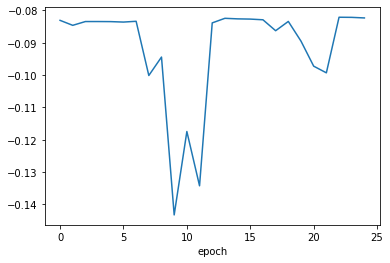

In [191]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [192]:
network = network.eval()

In [193]:
# Assign benchmarks. Recall: IBM does poorly. Amazon does well.
# First add the individual stocks
benchmarks = {asset_name: Singleton(asset_ix=i) for i, asset_name in enumerate(asset_names_batch)}

# Now add the others
benchmarks["1overN"] = OneOverN()  # each asset has weight 1 / n_assets
benchmarks["random"] = Random()  # random allocation that is however close 1OverN
benchmarks["network"] = network  # our trained network

# Include metrics. Selected two, since using only one bombs out at time of writing
# NOTE: We are using `simple` here for the mean return, whereas most of the training and data config above is in log-space by default.
metrics = {
    "Sharpe": SharpeRatio(),
    "MeanReturn": MeanReturns(output_type="simple"),
    "MaxDD": MaximumDrawdown(),
}


In [194]:
metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)

In [195]:
metrics_table['value'] *= -1

In [196]:
metrics_table.tail()

,timestamp,benchmark,metric,value
30,2020-05-29,network,MaxDD,0.000000
31,2020-08-11,network,MaxDD,-0.009349
32,2020-09-30,network,MaxDD,0.000000
33,2020-05-08,network,MaxDD,-0.024912
34,2020-07-01,network,MaxDD,-0.003705


/usr/local/lib/python3.7/dist-packages/deepdow/visualize.py:177: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f42a7e66790>,
      dtype=object)

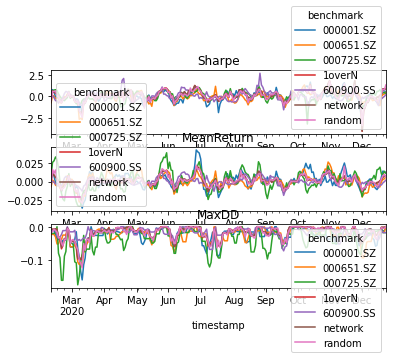

In [197]:
plot_metrics(metrics_table)

In [198]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,000001.SZ,000651.SZ,000725.SZ,600900.SS
2020-02-11,0.250889,0.241952,0.244609,0.262550
2020-02-12,0.247626,0.254887,0.239913,0.257573
2020-02-13,0.245944,0.257397,0.235633,0.261026
2020-02-14,0.246156,0.258011,0.232017,0.263817
2020-02-17,0.250181,0.259067,0.227669,0.263083
...,...,...,...,...
2020-12-17,0.238641,0.255263,0.230367,0.275729
2020-12-18,0.222073,0.253469,0.255252,0.269206
2020-12-21,0.237655,0.250917,0.245263,0.266165
2020-12-22,0.234797,0.249263,0.247687,0.268253


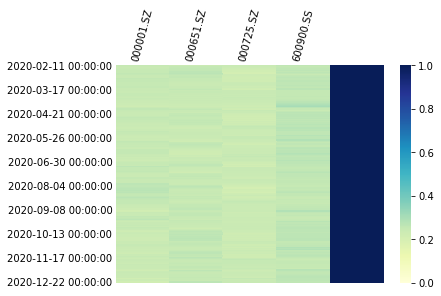

In [199]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [200]:
benchmark_num = metrics_table['benchmark'].unique()
metric_num = metrics_table['metric'].unique()

In [201]:
df2=pd.DataFrame(np.random.randn(len(benchmark_num),len(metric_num)),
                 index=list(benchmark_num),
                 columns=list(metric_num))
for i in benchmark_num:
  for j in metric_num:
    returns = metrics_table.query(f"(metric=='{j}') & (benchmark == '{i}')")
    index_num=list(benchmark_num).index(i)
    column_num=list(metric_num).index(j)
    df2.iloc[index_num][column_num]=returns['value'].mean()
    #print(index_num,column_num,returns['value'].mean())
print(df2)




             Sharpe  MeanReturn     MaxDD
000001.SZ  0.017102    0.001230 -0.025438
000651.SZ -0.050511    0.000017 -0.024723
000725.SZ  0.005574    0.001185 -0.035832
600900.SS  0.017514    0.000438 -0.015975
1overN     0.083312    0.000713 -0.017243
random     0.043226    0.000714 -0.018398
network    0.082388    0.000681 -0.016979
